# 人工蒐集資料分析

## 載入函示庫

In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels.stats.stattools as smss
import math
import statistics

In [2]:
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

In [3]:
def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

In [4]:
def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI

In [5]:
def Chi_Square_for_Normality(stand_res, N, a): 
    m = np.mean(stand_res)
    s = np.std(stand_res)
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s
    counts, bins = np.histogram(stand_res, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]   
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e)
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = freq_o.shape[0]-3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    
    return chi_pval

## 載入資料

In [6]:
df = pd.read_excel('Stat_2020_b_1_Regression.xlsx', sheet_name = 'all_data')
print('Head of dataset:')
display(df.head())

print("Tail of dataset:")
display(df.tail())

Head of dataset:


,date,comments,condition,total_price,tag,likes
0,2021-05-31,155,1,700,3,63
1,2021-05-31,48,1,200,2,43
2,2021-05-31,46,1,800,2,106
3,2021-05-31,54,1,400,2,33
4,2021-05-29,17,1,1000,2,31


Tail of dataset:


,date,comments,condition,total_price,tag,likes
209,2019-05-08,26,1,120,2,28
210,2019-04-30,72,1,240,2,59
211,2019-04-26,41,1,200,2,54
212,2019-04-23,29,1,750,2,70
213,2019-03-12,161,1,685,2,60


# 複回歸分析

X(independent variable) - total price(x1), likes(x2), condition: fill survey or not(x3) (fill survey = 1, no fill survey = 0), tag 2,3 people or not(x4) (2 or 3 people = 1, not two or three people = 0)

y(dependent variable) - Comments

### 1. Plot the scatter diagram

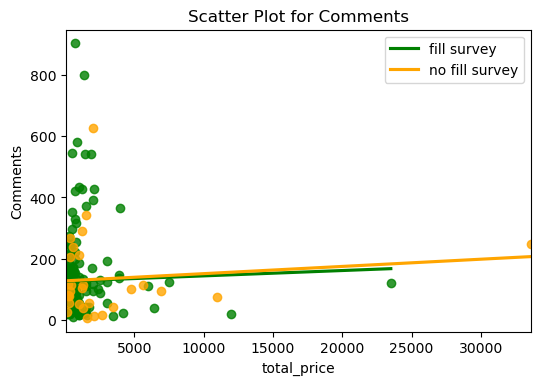

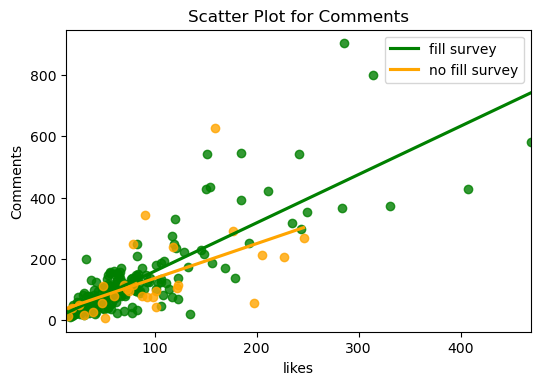

In [7]:
dfc1 = df[df.condition == 1]
dfc2 = df[df.condition == 2]
xnames = ['total_price','likes']
for aname in xnames:
    _ = sns.regplot(x=aname, y= 'comments', data = dfc1, color = 'green', ci = None)
    _ = sns.regplot(x=aname, y= 'comments', data = dfc2, color = 'orange', ci = None)
    plt.legend(labels=['fill survey', 'no fill survey'])
    plt.title('Scatter Plot for Comments')
    plt.xlabel(aname)
    plt.ylabel('Comments')
    plt.show()


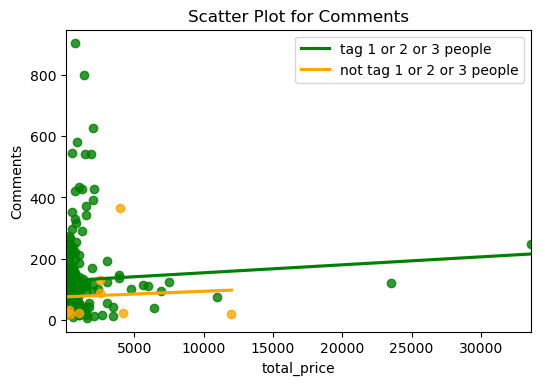

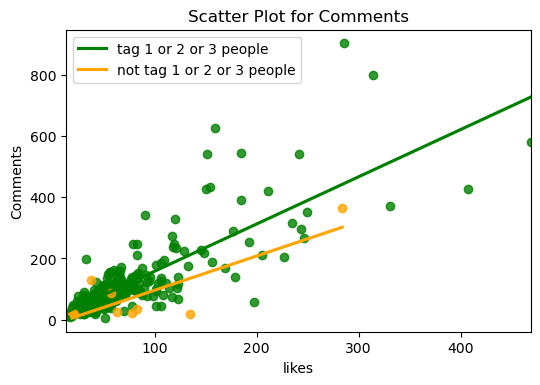

In [8]:
dfc1 = df[(df.tag == 2) | (df.tag == 3) | (df.tag == 1)]
dfc2 = df[(df.tag != 2) & (df.tag != 3) & (df.tag != 1)]
xnames = ['total_price','likes']
for aname in xnames:
    _ = sns.regplot(x=aname, y= 'comments', data = dfc1, color = 'green', ci = None)
    _ = sns.regplot(x=aname, y= 'comments', data = dfc2, color = 'orange', ci = None)
    plt.legend(labels=['tag 1 or 2 or 3 people', 'not tag 1 or 2 or 3 people'])
    plt.title('Scatter Plot for Comments')
    plt.xlabel(aname)
    plt.ylabel('Comments')
    plt.show()


In [9]:
df.describe()

,comments,condition,total_price,tag,likes
count,214.000000,214.000000,214.000000,214.000000,214.000000
mean,129.177570,1.135514,1293.355140,2.182243,82.616822
std,131.655748,0.343074,3126.725592,0.756482,68.113154
min,7.000000,1.000000,70.000000,0.000000,13.000000
25%,50.250000,1.000000,300.000000,2.000000,41.000000
50%,94.500000,1.000000,500.000000,2.000000,62.000000
75%,145.250000,1.000000,1000.000000,3.000000,100.250000
max,903.000000,2.000000,33602.000000,5.000000,469.000000


## 資料前處理

In [10]:
color_dummy = pd.get_dummies(df['condition'], prefix = 'condition')
color_dummy
df = pd.concat([df, color_dummy], axis = 1)
df.tail()

,date,comments,condition,total_price,tag,likes,condition_1,condition_2
209,2019-05-08,26,1,120,2,28,1,0
210,2019-04-30,72,1,240,2,59,1,0
211,2019-04-26,41,1,200,2,54,1,0
212,2019-04-23,29,1,750,2,70,1,0
213,2019-03-12,161,1,685,2,60,1,0


In [11]:
df.loc[(df['tag'] == 2) | (df['tag'] == 3) | (df['tag'] == 1), 'tags_123'] = 1 
df.loc[(df['tag'] != 2) & (df['tag'] != 3)  & (df['tag'] != 1), 'tags_123'] = 0 

In [12]:
df.drop(columns = ['condition_2', 'condition', 'tag'], inplace=True)

In [13]:
df

,date,comments,total_price,likes,condition_1,tags_123
0,2021-05-31,155,700,63,1,1.0
1,2021-05-31,48,200,43,1,1.0
2,2021-05-31,46,800,106,1,1.0
3,2021-05-31,54,400,33,1,1.0
4,2021-05-29,17,1000,31,1,1.0
...,...,...,...,...,...,...
209,2019-05-08,26,120,28,1,1.0
210,2019-04-30,72,240,59,1,1.0
211,2019-04-26,41,200,54,1,1.0
212,2019-04-23,29,750,70,1,1.0


In [14]:
y = df['comments']

X_ar = np.array([df['total_price'], df['likes'], df['condition_1'], df['tags_123']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = ['total_price', 'likes', 'condition_1', 'tags_123'])
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
result = olsmod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               comments   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     88.81
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           5.67e-44
Time:                        11:43:50   Log-Likelihood:                -1241.2
No. Observations:                 214   AIC:                             2492.
Df Residuals:                     209   BIC:                             2509.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -83.5052     33.861     -2.466      

In [15]:
st, data, ss2 = sso.summary_table(result, alpha=0.05)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]

### Check Normality
H0 : Normal distributed

H1 : Not normal distributed

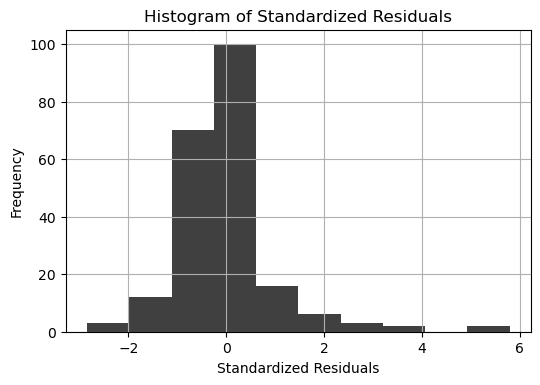

[  3.  12.  70. 100.  16.   6.   3.   2.   0.   2.]
[-2.8424348  -1.97861451 -1.11479422 -0.25097393  0.61284635  1.47666664
  2.34048693  3.20430722  4.0681275   4.93194779  5.79576808]
Shapiro Test: Statistics=0.812380, p=0.000000
Chi-squared test: statistics = 68.8679, p-value = 0.0000
Critical value = 3.8415 (defree of freedom = 1)


In [16]:
# Normality: Histogram
counts, bins, patches = plt.hist(SD, 10, density=False, facecolor='black', alpha=0.75)

plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()

print(counts)
print(bins)


stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

# Normality: Chi_Square
chi2_pval = Chi_Square_for_Normality(SD, 4, 0.05) 

##### Since the Normality test does not pass, we transform y to log y and see if there is a better result.

In [17]:
comments_log = np.log(df['comments'])

In [18]:
df.insert(loc=1, column='comments_log', value=comments_log)

In [19]:
y = df['comments_log']

X_ar = np.array([df['total_price'], df['likes'], df['condition_1'], df['tags_123']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = ['total_price', 'likes', 'condition_1', 'tags_123'])
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
result = olsmod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           comments_log   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     59.30
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           2.15e-33
Time:                        11:43:51   Log-Likelihood:                -191.08
No. Observations:                 214   AIC:                             392.2
Df Residuals:                     209   BIC:                             409.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7341      0.250     10.923      

In [20]:
st, data, ss2 = sso.summary_table(result, alpha=0.05)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]

### Check Normality
H0 : Normal distributed

H1 : Not normal distributed

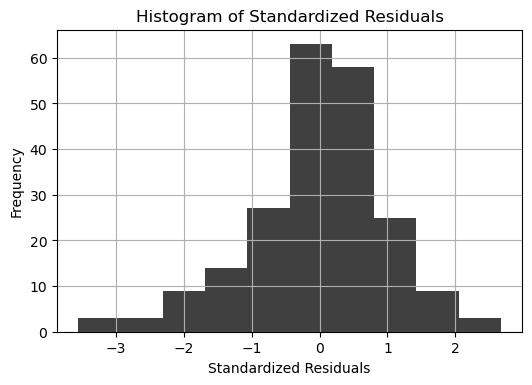

[ 3.  3.  9. 14. 27. 63. 58. 25.  9.  3.]
[-3.55252114 -2.93035822 -2.30819531 -1.6860324  -1.06386949 -0.44170657
  0.18045634  0.80261925  1.42478216  2.04694507  2.66910799]
Shapiro Test: Statistics=0.972861, p=0.000383


In [21]:
# Normality: Histogram
counts, bins, patches = plt.hist(SD, 10, density=False, facecolor='black', alpha=0.75)

plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()

print(counts)
print(bins)


stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))


The Shapiro test does not pass. In order to pass the Shapiro test, we try to delete outliers.

#### Outliers

In [22]:
# outliers
df_c = pd.DataFrame(SD,columns = ['SD'])
filter = (df_c['SD'] < -2) | (df_c['SD'] > 2)
print("Outliers by SD = ")
print(df_c['SD'].loc[filter])
outliers = df_c['SD'].loc[filter]
print("Actual ID: ",df_c['SD'].loc[filter].index+1)

Outliers by SD = 
4     -2.106656
63    -2.954187
64     2.467165
86    -2.450610
105    2.443873
106   -3.046496
115   -2.544106
155   -2.196713
161   -2.523097
186    2.669108
188   -3.552521
Name: SD, dtype: float64
Actual ID:  Int64Index([5, 64, 65, 87, 106, 107, 116, 156, 162, 187, 189], dtype='int64')


In [23]:
df.drop(outliers.index, inplace = True)

In [24]:
df = df.reset_index(drop=True)

In [25]:
y = df['comments_log']

X_ar = np.array([df['total_price'], df['likes'], df['condition_1'], df['tags_123']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = ['total_price', 'likes', 'condition_1', 'tags_123'])
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
result = olsmod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           comments_log   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     84.40
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           1.04e-41
Time:                        11:43:51   Log-Likelihood:                -139.54
No. Observations:                 203   AIC:                             289.1
Df Residuals:                     198   BIC:                             305.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5205      0.225     11.204      

In [26]:
st, data, ss2 = sso.summary_table(result, alpha=0.05)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]

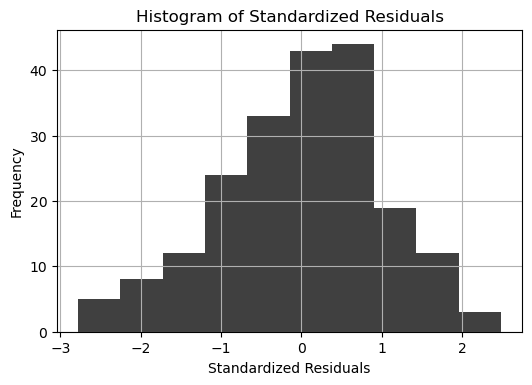

[ 5.  8. 12. 24. 33. 43. 44. 19. 12.  3.]
[-2.77822798 -2.2521175  -1.72600701 -1.19989653 -0.67378605 -0.14767557
  0.37843491  0.90454539  1.43065587  1.95676635  2.48287683]
Shapiro Test: Statistics=0.987325, p=0.067216
Chi-squared test: statistics = 0.9606, p-value = 0.3270
Critical value = 3.8415 (defree of freedom = 1)


In [27]:
# Normality: Histogram
counts, bins, patches = plt.hist(SD, 10, density=False, facecolor='black', alpha=0.75)

plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()

print(counts)
print(bins)

stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

# Normality: Chi_Square
chi2_pval = Chi_Square_for_Normality(SD, 4, 0.05) 

The Shapiro test now passes. Check the other required conditions.

### Runs Test

H0 : Independence
    
H1 : Not independence

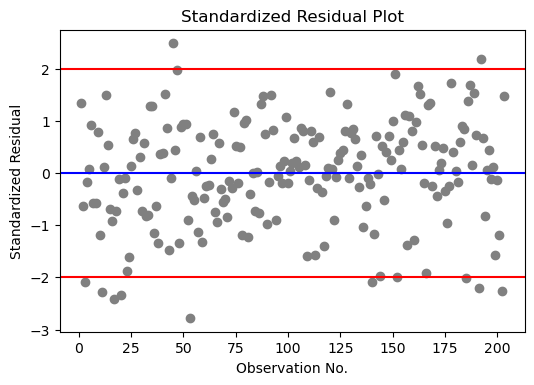

runs =  87
n1 =  102
n2 =  101
runs_exp =  102.49753694581281
stan_dev =  7.1060748203268504
z =  -2.1808856981750706
pval_z =  0.029191871798067075
p_value for Z-statistic=  0.029191871798067075


In [28]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

Since n1>20 and n2>20, we can apply run test with normal distribution.
Since p-value < alpha = 0.05, we cannot reject H0 at significance level at alpha = 0.05.
Thus we cannot assume the sample is randomly selected. Try adding time series to solve the problem.

In [29]:
df['Week_Number'] = df['date'].dt.week
df

/Users/judy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,date,comments_log,comments,total_price,likes,condition_1,tags_123,Week_Number
0,2021-05-31,5.043425,155,700,63,1,1.0,22
1,2021-05-31,3.871201,48,200,43,1,1.0,22
2,2021-05-31,3.828641,46,800,106,1,1.0,22
3,2021-05-31,3.988984,54,400,33,1,1.0,22
4,2021-05-29,4.189655,66,70,41,1,1.0,21
...,...,...,...,...,...,...,...,...
198,2019-05-08,3.258097,26,120,28,1,1.0,19
199,2019-04-30,4.276666,72,240,59,1,1.0,18
200,2019-04-26,3.713572,41,200,54,1,1.0,17
201,2019-04-23,3.367296,29,750,70,1,1.0,17


In [30]:
y = df['comments_log']

X_ar = np.array([df['total_price'], df['likes'], df['condition_1'], df['tags_123'], df['Week_Number']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = ['total_price', 'likes', 'condition_1', 'tags_123', 'Week_Number'])
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
result = olsmod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           comments_log   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     69.92
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           8.53e-42
Time:                        11:43:52   Log-Likelihood:                -136.96
No. Observations:                 203   AIC:                             285.9
Df Residuals:                     197   BIC:                             305.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2784      0.247      9.213      

In [31]:
st, data, ss2 = sso.summary_table(result, alpha=0.05)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]

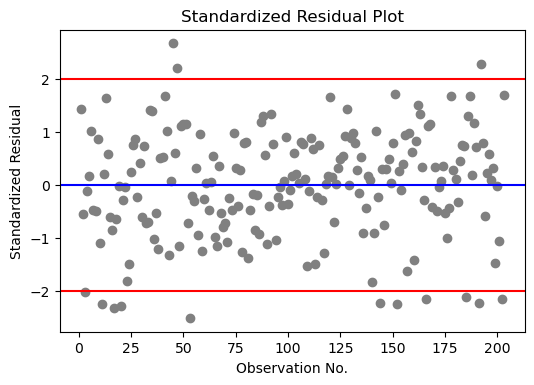

runs =  93
n1 =  102
n2 =  101
runs_exp =  102.49753694581281
stan_dev =  7.1060748203268504
z =  -1.3365377069553517
pval_z =  0.18137358434578132
p_value for Z-statistic=  0.18137358434578132


In [32]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

The p-value is now larger than 0.05. So now we apply full steps of multiple regression and see if all requried conditions are met.

### 2. Propose a statistical model 

Comments = $\beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \beta_3 * x_3 + \beta_4 * x_4 + \beta_4 * x_5$  

x1 = total_price(NTD)

x2 = likes

x3 = condition_1 (indicator variable, = 1 if have to fill survey, = 0 if don't have to fill survey)

x4 = tags_123 (indicator variable, = 1 if have to tag 1 or 2 or 3 people, = 0 otherwise)

x5 = Week_Number

### 3. Fit the model

In [33]:
y = df['comments_log']

X_ar = np.array([df['total_price'], df['likes'], df['condition_1'], df['tags_123'], df['Week_Number']])
X_T =X_ar.T
X = pd.DataFrame(X_T,columns = ['total_price', 'likes', 'condition_1', 'tags_123', 'Week_Number'])
X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
result = olsmod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           comments_log   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     69.92
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           8.53e-42
Time:                        11:43:53   Log-Likelihood:                -136.96
No. Observations:                 203   AIC:                             285.9
Df Residuals:                     197   BIC:                             305.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2784      0.247      9.213      

In [34]:
print("Estimated model: y = %0.4f" % (result.params[0]), end = ' ')
for c, x in zip(result.params[1:], list(range(1,6))):
    print('+', end = '') if c> 0 else print('-', end = '')
    print(" %0.6f x%d " % (abs(c), x), end = '') 


Estimated model: y = 2.2784 + 0.000027 x1 + 0.010225 x2 + 0.352764 x3 + 0.954523 x4 + 0.004858 x5 

### 4. Requirements Check 

In [35]:
st, data, ss2 = sso.summary_table(result, alpha=0.05)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]

In [36]:
df.drop(columns = ['comments'], inplace = True)

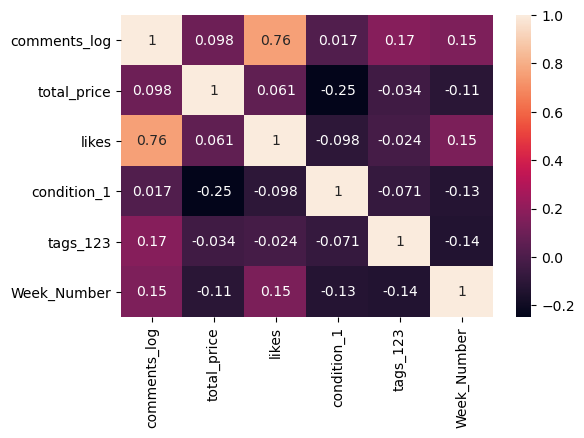

In [37]:
corr = df.corr()
_ = sns.heatmap(corr, annot=True)

#### Multicollinearity

1. The correlation between independent variables are all smaller than 0.7.

2. And the signs for x1-x4's correlation coefficients and coefficients are same.

Thus, Multicollinearity doesn't exist.

#### Outliers

In [38]:
# outliers
df_c = pd.DataFrame(SD,columns = ['SD'])
filter = (df_c['SD'] < -2) | (df_c['SD'] > 2)
print("Outliers by SD = ")
print(df_c['SD'].loc[filter])
outliers = df_c['SD'].loc[filter]
print("Actual ID: ",df_c['SD'].loc[filter].index+1)

Outliers by SD = 
2     -2.019564
10    -2.243932
16    -2.337879
19    -2.289994
44     2.675606
46     2.216458
52    -2.517918
143   -2.235706
151   -2.262358
165   -2.151963
184   -2.111848
190   -2.229411
191    2.284932
201   -2.160856
Name: SD, dtype: float64
Actual ID:  Int64Index([3, 11, 17, 20, 45, 47, 53, 144, 152, 166, 185, 191, 192, 202], dtype='int64')


#### Influential observations

In [39]:
X = np.array(X)
H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))

df['hii'] = np.diagonal(H)
df_h = pd.DataFrame(df['hii'])
k = result.df_model
n = len(df_h['hii'])
h_level = 3 * (k+1) / n 
print("h_level = ", h_level)
print(" \n")
filter = (df_h['hii'] > h_level )
print("Influential Observations by hi = \n")

print(df_h['hii'].loc[filter])
print("Actual ID: ",df_h['hii'].loc[filter].index+1)

h_level =  0.08866995073891626
 

Influential Observations by hi = 

52     0.117343
58     0.285604
71     0.151523
77     0.144328
81     0.144902
83     0.090206
121    0.154522
146    0.152619
179    0.201931
188    0.557852
191    0.145622
193    0.089920
Name: hii, dtype: float64
Actual ID:  Int64Index([53, 59, 72, 78, 82, 84, 122, 147, 180, 189, 192, 194], dtype='int64')


### Normality

H0 : Normal distributed

H1 : Not normal distributed

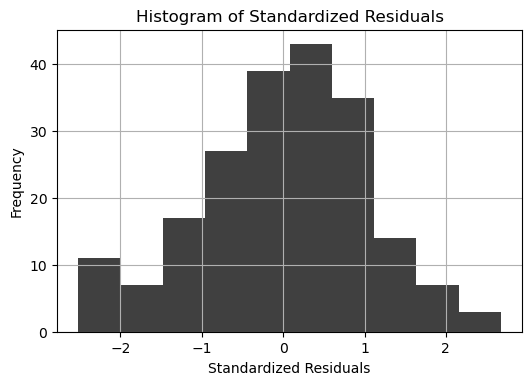

[11.  7. 17. 27. 39. 43. 35. 14.  7.  3.]
[-2.51791846 -1.99856604 -1.47921363 -0.95986121 -0.44050879  0.07884363
  0.59819604  1.11754846  1.63690088  2.15625329  2.67560571]
Shapiro Test: Statistics=0.987261, p=0.065733
Chi-squared test: statistics = 1.5517, p-value = 0.2129
Critical value = 3.8415 (defree of freedom = 1)


In [40]:
# Normality: Histogram
counts, bins, patches = plt.hist(SD, 10, density=False, facecolor='black', alpha=0.75)

plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()

print(counts)
print(bins)

stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

# Normality: Chi_Square
chi2_pval = Chi_Square_for_Normality(SD, 4, 0.05) 


Since p-value for both Shapiro and Chi-squared > alpha = 0.05, we can not reject H0 at significance level at alpha = 0.05.
There is no evidence to show that it is not normally distributed.

### Homoscedasticity

H0 : Homoscedasticity
H1 : Not Homoscedasticity

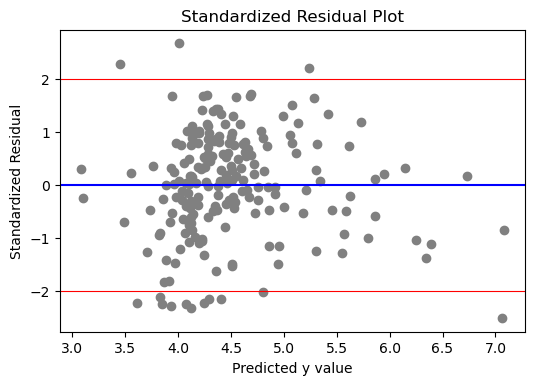

In [41]:
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=2, color = 'red', lw = 0.8)
plt.axhline(y=0, color = 'blue')
plt.axhline(y=-2, color = 'red', lw = 0.8)
plt.title('Standardized Residual Plot')
plt.xlabel('Predicted y value')
plt.ylabel('Standardized Residual')
plt.show()

We do not reject H0. We can assume the variation is constant and the mean is around 0.

### Independence

H0 : Independence
    
H1 : Not independence

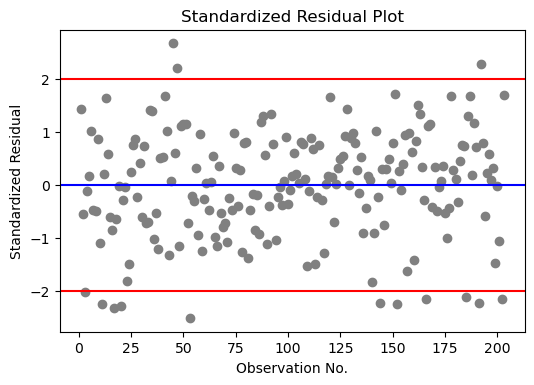

runs =  93
n1 =  102
n2 =  101
runs_exp =  102.49753694581281
stan_dev =  7.1060748203268504
z =  -1.3365377069553517
pval_z =  0.18137358434578132
p_value for Z-statistic=  0.18137358434578132


In [42]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

Since n1>20 and n2>20, we can apply run test with normal distribution.
Since p-value > alpha = 0.05, we cannot reject H0 at significance level at alpha = 0.05.
Thus we cannot assume the sample is not randomly selected.

#### Autocorreltaion

H0: The data are not positively first-order correlated

H1: The data are positively first-order correlated

In [43]:
d_w = Durbin_Watson_test(SD)
print(d_w)

x_square_sum =  203.8425628660268
size =  203
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_d =  [ 0.         -1.98609688 -1.46449442  1.91138485  0.27653018  0.85845846
 -1.49461968 -0.02250616  1.36307242 -1.97789737 -1.1387912   2.45197912
  1.43553187 -1.06387646 -1.19212749 -0.24960555 -1.47584814  1.69915026
  0.62199052 -2.27325629  1.99521276  0.25231352 -1.77532957  0.32521611
  1.72960772  0.52589713  0.1

Because the durbin watson critical value table is only up to 200, we use 200 as approximation of sample size.

Since dU < d= 1.9057109405561456 < 4-dU, we can not reject H0.

Thus, there is not enough evidence to infer that first order auto-correlation exist.

### 5. Assess the fitted model 

In [44]:
print("standard error = ", result.mse_resid ** 0.5)
print("mean of y", data[:, 1].mean())
print("std of y", data[:, 1].std())
print("R-Squared = ", result.rsquared)
print("Adjusted R-Squared = ",result.rsquared_adj)
f_res = result.fvalue
print("F value = ", f_res)
MSE = result.mse_resid
df_model = result.df_model
df_error = result.df_resid
MSR = f_res * MSE
SSR = MSR* df_model
print("SSR = ", SSR, "df = ", df_model, "MSR = ", MSR)
print("SSE = ", MSE * df_error, "df = ", df_error, "MSE = ", MSE)
print("F = ", MSR / MSE)
A = np.identity(len(result.params))
A = A[1:,:]
print("F test = ", result.f_test(A))

standard error =  0.48227811014934974
mean of y 4.50595139515934
std of y 0.7913841654376857
R-Squared =  0.639595191742671
Adjusted R-Squared =  0.6304478615838556
F value =  69.92151596564827
SSR =  81.315987573759 df =  5.0 MSR =  16.263197514751802
SSE =  45.82065857925798 df =  197.0 MSE =  0.2325921755292283
F =  69.92151596564827
F test =  <F test: F=array([[69.92151597]]), p=8.533814530271676e-42, df_denom=197, df_num=5>


####  Standard Error of Estimate

Compared to y_bar, Se is relatively small. Hence our regression model of is good.

#### R2
R2 = 0.6395951917426709 which means about 64.0% of the variation in comments is explained by this model. The rest(36.0%) remains unexplained by this model. Difference between r-squared and adjusted r-squared is low(< 0.06), so the model has not problem of over-fitting.


#### F test

H0: $\beta_1$ = $\beta_2$ = $\beta_3 =  \beta_4 = \beta_5 = 0$  

H1: At least one $\beta_i$ is not equal to zero. (i = 1,2,3,4,5)

p-value of F statistic is 8.533814518904075e-42 < 0.05, rejects null hypothesis, there is enough evidence to conclude At least one $\beta_i$ is not equal to zero, the model is valid.

#### T test of Coeffiecients

for i = 1,2,3,4,5

H0:  $\beta_i = 0$
    
H1:  $\beta_i \neq 0$



p-value of total_price =  0.018. Since p-value < alpha = 0.05, we reject H0 at significance level at alpha = 0.05.
<br>There's enough evidence to infer that the total price is an important variable in the linear regression model of comments.

p-value of likes = 0.000. Since p-value < alpha = 0.05, we reject H0 at significance level at alpha = 0.05. 
<br>There's enough evidence to infer that the number of likes is an important variable in the linear regression model of comments.

p-value of condition_1 = 0.001. Since p-value < alpha = 0.05, we reject H0 at significance level at alpha = 0.05. 
<br>There's enough evidence to infer that the condition (whether to fill a survey) is an important variable in the linear regression model of comments.

p-value of tags_123 = 0.000. Since p-value < alpha = 0.05, we reject H0 at significance level at alpha = 0.05. 
<br>There's enough evidence to infer that the required number of people tagged (1 to 3 people or otherwise) is an important variable in the linear regression model of comments.

p-value of Week_Number = 0.026. Since p-value < alpha = 0.05, we reject H0 at significance level at alpha = 0.05. 
<br>There's enough evidence to infer that the week number is an important variable in the linear regression model of comments.

### 6. Interpretation

Model:
    
y = 2.2784 + 0.000027 x1 + 0.010225 x2 + 0.352764 x3 + 0.954523 x4 + 0.004858 x5 

b0=2.2784: This is the intercept, the value of y when all the variables take the value zero. Since the data range of all the independent variables do not cover the value zero, do not interpret the intercept.

b1=0.000027: In this model, for each additional NTD dollar, the logarithm of number of comments would increase by 0.000027(assuming the other variables are held constant).

b2=0.010225: In this model, for each additional like, the logarithm of number of comments would increase by 0.010225(assuming the other variables are held constant).

b3=0.352764: In this model, if you fill survey, the logarithm of number of comments would be 0.352764 more than if you don't fill survey(assuming the other variables are held constant).

b4=0.954523: In this model, if you tag 1 or 2 or 3 people, the logarithm of number of comments would be 0.954523 more than if you don't tag 1 or 2 or 3 people(assuming the other variables are held constant).

b5=0.004858: In this model, for each additional week, the logarithm of number of comments would increase by 0.004858 (assuming the other variables are held constant).

### 7. Apply for prediction 

As an example, assume total_price = 500, likes = 60, tags_123 = 1, condition_1 = 1, week = 23

In [45]:
xg = np.array([1, 500, 60, 1, 1, 23])
CI_PI_result = CI_PI_regression(X_ar, y, xg, 0.05)
print(CI_PI_result)

make CI and PI prediction at mean of x =  [  1 500  60   1   1  23]
y_head =  4.324570820469244
confidence interval of mean = [4.2431, 4.4060] 
Prediction interval = [3.3700, 5.2791] 
[4.24310129 4.40604035 3.36999735 5.27914429]


We predict that the logarithm of comments will fall between 3.3700 and 5.2791

We predict that the mean logarithm of comments will fall between 4.2431 and 4.4060

We transform logarithm of comments back to comments to see the final result.

In [46]:
CI_PI_result_exp = np.exp(CI_PI_result)
print(CI_PI_result_exp)

[ 69.62343976  81.94434949  29.07844989 196.2019125 ]


We predict that comments will fall between 29.07844989 and 196.2019125

We predict that the mean of comments will fall between 69.62343976 and 81.94434949